# Определение возраста покупателей

План работы:

**Введение:**

Описание задачи: Определение возраста людей.


**Исследовательский анализ данных:**

*Загрузка и предобработка изображений:*
Использование ImageDataGenerator для масштабирования изображений и создания генераторов для обучающей и тестовой выборок.
*Анализ данных:*
Изучение основных характеристик данных, обнаружение дубликатов и пропущенных значений.
*Визуализация данных:* 
Построение гистограммы распределения возрастов в наборе данных.

**Обучение модели:**

*Подготовка функций для загрузки и аугментации данных:*
Определение функций load_train() и load_test() для создания генераторов данных.

*Создание модели:* 
Использование предобученной архитектуры ResNet50 для построения модели, добавление слоев для предсказания возраста.

*Компиляция модели:* 
Настройка оптимизатора, функции потерь и метрик для обучения.

*Обучение модели:*
Использование функции train_model() для обучения модели на обучающей выборке и валидации на тестовой выборке.

**Анализ обученной модели:**

*Оценка результатов обучения:* 
Анализ значений потерь и метрик MAE на обучающей и тестовой выборках.
*Выводы:*
Обсуждение результатов, обозначение успешности модели и её точности на тестовой выборке.

## Исследовательский анализ данных

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

загрузим таблицу с названиями файлов и таргетом

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


посмотрим сколько батчей

In [3]:
len(train_datagen_flow)

238

In [4]:
print(labels.info())
labels.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Пропусков нет

In [5]:
labels.duplicated().sum()

0

Дубликатов нет

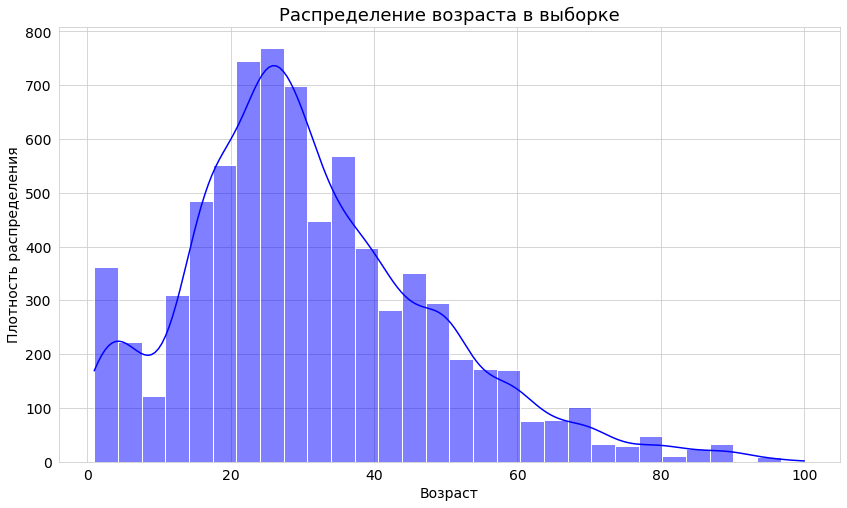

In [10]:
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')
sns.histplot(labels["real_age"], kde=True, bins=100, color='blue')
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.title('Распределение возраста в выборке', fontsize=18, color='black')
plt.ylabel('Плотность распределения', fontsize=14, color='black')
plt.xlabel('Возраст', fontsize=14, color='black')
plt.show()


Как мы видим, распределение близко к нормальному, за исключением пика около 0. То есть в выборке есть люди, которым 1-2 года. 

Посмотрим, действительно ли им столько лет - возьмем первые 3 фотографии людей, которым по одному году

In [11]:
age_one = list(labels[labels['real_age'] < 2].head(5)['file_name'])

Напишем функцию для получения фотографии по названию файла

In [12]:
def get_image_by_filename(filenames):
    images_path = '/datasets/faces/final_files/'

    plt.figure(figsize=(15, 5))
    
    for i, filename in enumerate(filenames):
        image = Image.open(f'{images_path}{filename}')
        array = np.array(image)
        array = array/255

        plt.subplot(1, 3, i+1)
        plt.imshow(array, cmap='gray')
        plt.colorbar()
        plt.axis('off')


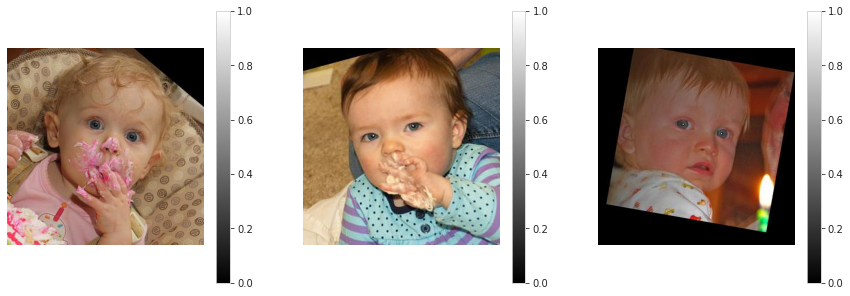

In [21]:
get_image_by_filename(age_one[:3])

Похоже же что им действительно так мало лет.
Также делаем вывод, что выборка клиентов содержит бОльшее кол-во молодых людей, чем пожилых, что может сказать на модели, так как может нехватить примеров фотографий людей старшего возраста

Оценим датасет по другим возрастным группам

In [22]:
age_10_15 = list(labels[(labels['real_age'] >= 10) & (labels['real_age'] < 16)]
                 .sample(5)['file_name'])

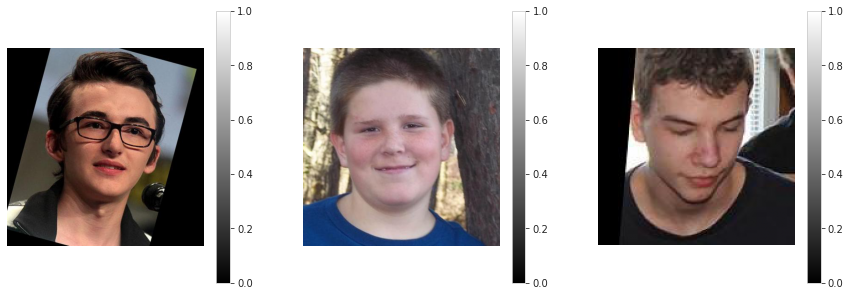

In [23]:
get_image_by_filename(age_10_15[:3])

In [24]:
age_25_30 = list(labels[(labels['real_age'] >= 25) & (labels['real_age'] < 31)]
                 .sample(5)['file_name'])

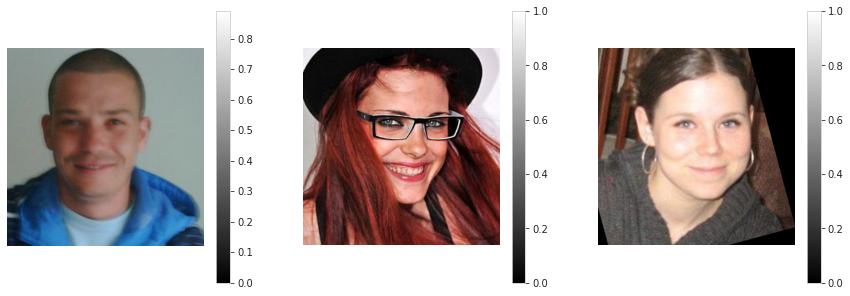

In [25]:
get_image_by_filename(age_25_30[:3])

In [26]:
age_45_50 = list(labels[(labels['real_age'] >= 45) & (labels['real_age'] < 51)]
                 .sample(5)['file_name'])

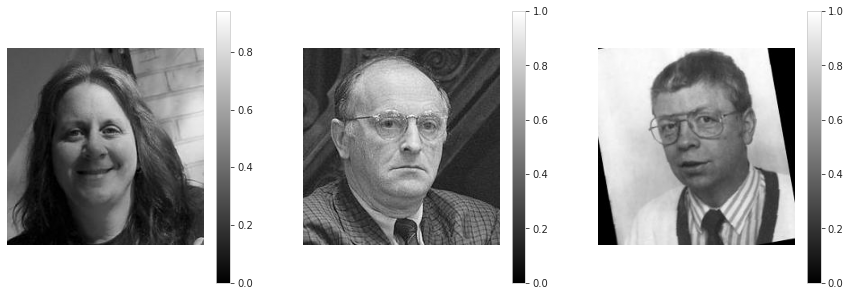

In [27]:
get_image_by_filename(age_45_50[:3])

In [28]:
age_70_90 = list(labels[(labels['real_age'] >= 70) & (labels['real_age'] < 91)]
                 .sample(5)['file_name'])

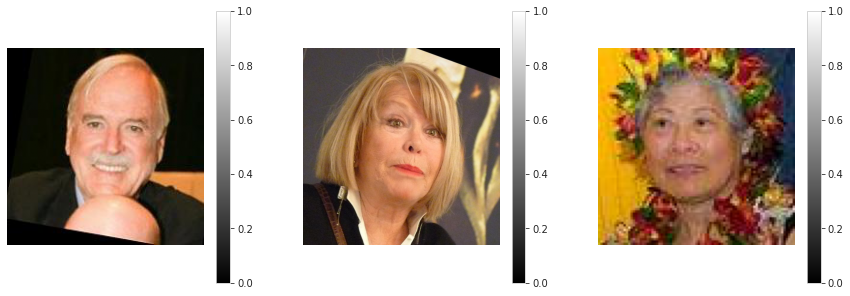

In [29]:
get_image_by_filename(age_70_90[:3])

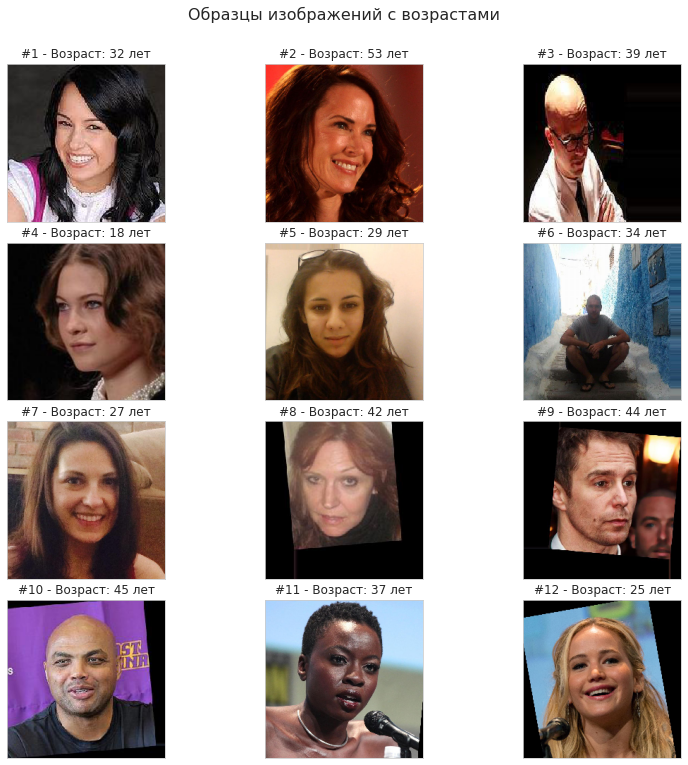

In [38]:
features, target = next(train_datagen_flow)

fig = plt.figure(figsize=(14, 10))
for i in range(12):
    ax = fig.add_subplot(4, 3, i + 1)
    plt.imshow(features[i], cmap='viridis') 
    plt.xticks([])
    plt.yticks([])
    plt.title(f"#{i+1} - Возраст: {int(target[i])} лет")
    plt.tight_layout(pad=0.5) 

fig.suptitle('Образцы изображений с возрастами', fontsize=16, y=1.05) 
plt.show()


Итак, что мы имеем перед началом обучения:

1. У нас довольно большой датасет с 7,5 тыс изображениями людей разного возраста
2. Выборка немного смещена в сторону молодых людей, что в теории может сказать на качестве обучения + имеем большое кол-во младенцев (1-2 года)
3. У всех фотографий разное разрешением, нам нужны фотографии 224х224

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    
    validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return val_datagen_flow 

def create_model(input_shape):
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', 
              metrics=[keras.metrics.MeanAbsoluteError()])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/5

178/178 - 80s - loss: 289.2911 - mean_absolute_error: 11.8746 - val_loss: 553.8649 - val_mean_absolute_error: 18.4901
Epoch 2/5
178/178 - 54s - loss: 68.6804 - mean_absolute_error: 6.2702 - val_loss: 646.0229 - val_mean_absolute_error: 20.2971
Epoch 3/5
178/178 - 58s - loss: 32.3898 - mean_absolute_error: 4.3903 - val_loss: 352.1843 - val_mean_absolute_error: 13.9104
Epoch 4/5
178/178 - 60s - loss: 20.7634 - mean_absolute_error: 3.4847 - val_loss: 107.1232 - val_mean_absolute_error: 7.9237
Epoch 5/5
178/178 - 63s - loss: 16.0216 - mean_absolute_error: 3.0907 - val_loss: 78.3088 - val_mean_absolute_error: 6.7745

60/60 - 10s - loss: 78.3088 - mean_absolute_error: 6.6945
Test MAE: 6.6945
```


## Анализ обученной модели

Исходя из данных, зарегистрированных в журнале тренировок, мы можем сделать следующие выводы:

Наша модель, основанная на предварительно обученной архитектуре **ResNet50** с использованием весов, обученных на датасете ImageNet, успешно справилась с задачей предсказания возраста. Давайте рассмотрим более детально архитектуру модели и стратегию обучения:

**Архитектура Модели**
1. *Первый слой*: ResNet50 с весами ImageNet была выбрана в качестве основной архитектуры (исключая верхний слой классификации), предоставляя мощный слой для извлечения признаков.
2. *Второй слой*: Применение GlobalAveragePooling2D позволило усреднить характеристики по пространственным измерениям, уменьшая размерность, но сохраняя важную информацию.
3. *Третий слой*: Полносвязный слой (Dense) с одним нейроном и функцией активации ReLU применяется для финального предсказания возраста.

**Стратегия Оптимизации**
- *Оптимизатор*: Adam был выбран как оптимизатор с начальным коэффициентом обучения 0.0001. Это значение было установлено после серии экспериментов, которые показали, что повышение скорости обучения фактически ускоряет сходимость модели, указывая на необходимость более быстрой адаптации по сравнению с базовым набором данных ImageNet.
- *Функция потерь и метрика*: Для задачи регрессии возраста была применена функция потерь MSE (Mean Squared Error), а в качестве метрики выбрана MAE (Mean Absolute Error), которая дает представление о среднем абсолютном отклонении предсказанных возрастов от реальных значений.

**Анализ Результатов**

Модель продемонстрировала устойчивое улучшение в течение всего периода обучения, с каждой эпохой значительно снижая значение функции потерь и ошибки MAE. Финальная ошибка MAE на тестовом наборе данных достигла 6.6945, что свидетельствует о высокой точности предсказаний модели и подтверждает ее способность эффективно обобщать новые данные, достигая приемлемой степени точности в предсказаниях возраста.
